### P73 선형 회귀 모델
- 데이터를 선형 함수로 모델링
- 최소제곱법 : 평균제곱오차를 최소화하는 파라미터를 찾는다.
  - 파라미터를 줄이고 키우고를 반복한다.(예시)
  - 오차를 파라미터로 이분한 값만큼 조절한다.(경사하강법)
  - 정규방정식으로 찾기(데이터가 많아지면 메모리 부족으로 사용 불가)
- 평균제곱오차 : 오차(예측과 정답의 차이)를 제곱 > 모든 샘플들의 오차를 평균


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
# 키와 몸무게, 뭄무게로부터 키를 예측해보자
몸무게 = [30,60,70,90]
키 = [120, 160, 170, 190]
몸무게_test = [65, 80]  # 이 두사람의 키는 어떻게 될까??

In [8]:
# 4행 1열/1행 4열(wrong)
몸무게 = np.array(몸무게).reshape((-1,1))
키 = np.array(키)
몸무게_test = np.array(몸무게_test).reshape((-1,1))

In [5]:
# P76 모델 선택
from sklearn.linear_model import LinearRegression

In [10]:
lr = LinearRegression()
lr.fit(X=몸무게, y=키) # Y = w*x+b 에서 w와 b를 조정하는 것

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [11]:
몸무게_test, lr.predict(몸무게_test)

(array([[65],
        [80]]), array([162.93333333, 180.53333333]))

In [14]:
lr.score(몸무게,키) # 결정계수 max 1

0.9928205128205129

In [15]:
# 계수 w와 절편 b, Y = wx + b = 1.17 * x + 86.6
lr.coef_, lr.intercept_

(array([1.17333333]), 86.66666666666667)

In [16]:
lr.coef_ * 몸무게 + lr.intercept_  # Y = w * x + b

array([[121.86666667],
       [157.06666667],
       [168.8       ],
       [192.26666667]])

In [19]:
키

array([120, 160, 170, 190])

## LinearRegression으로 내일의 종가 예측
- 입력(X:하루 전 데이터), 출력(Y:다음 날의 종가)
- 데이터 총 갯수 : m = 10, 학습용 8, 테스트 2
- 정규화는 일단 생략

In [20]:
url = 'file:///C:/Users/wtime/Downloads/머신런닝/코스피200%20_%20다음%20금융.html'
tables = pd.read_html(url, encoding='cp949', index_col=0) # 1번째 컬럼이 index다.
len(tables)

3

In [21]:
for table in tables :
    print(table.shape)

(10, 6)
(10, 8)
(10, 7)


In [22]:
df = tables[1]

In [23]:
df.head()

,종가,전일비,등락률,거래량,거래대금,개인(억),외국인(억),기관(억)
일자,,,,,,,,
19.07.02,276.87,▼0.40,-0.14%,22592,826628,318,84,-382
19.07.01,277.27,▼0.23,-0.08%,74357,3446049,-214,1286,365
19.06.28,277.50,▼0.25,-0.09%,67598,2879563,-1802,3011,-1189
19.06.27,277.75,▲2.22,+0.81%,66303,3357666,-4165,1837,2415
19.06.26,275.53,▲0.25,+0.09%,58818,2636531,-712,157,557


In [44]:
# 전일비와 등락률을 수치데이터(실수 : float)로 변환
# 전일비에 특수문자 : ▼, ▲ 존재 -> 삭제 필요
# 등락률에 특수문자 : % 존재 -> 삭제 필요
df['전일비']= df['전일비'].replace('▼', '-',regex=True)
df['전일비']= df['전일비'].replace('▲', '',regex=True)
df['등락률']= df['등락률'].replace('%', '',regex=True)
df['전일비'] = df['전일비'].astype(np.float)
df['등락률'] = df['등락률'].astype(np.float)

In [51]:
# min, max 정규화 [0,1]
minimum = np.min(df, axis = 0)
maximum = np.max(df, axis = 0)
df_norm = (df - minimum) / (maximum-minimum)

In [85]:
범주 = df.index
범주.shape

(10,)

In [58]:
# x와 y를 분리
#X = df.iloc[1:] # 오늘을 제외한 모든 데이타
#y = df.iloc[:-1, 0]  # 가장 오래된 데이터와 종가 외의 컬럼 제외
X = df_norm.iloc[1:] # 오늘을 제외한 모든 데이타
y = df_norm.iloc[:-1, 0]  # 가장 오래된 데이터와 종가 외의 컬럼 제외

X.shape, y.shape

((9, 8), (9,))

In [59]:
# Train/ Test용 분리
from sklearn.model_selection import train_test_split
offset = 2
X_train = X[offset:]  # 예전 data
X_test = X[:offset]   # 최근 data
y_train = y[offset:]  # 예전 data
y_test = y[:offset]   # 최근 data

In [63]:
# train으로 Linear Regression 모델 fit
# P78 릿지(ridge) 모델 : w를 가능한한 작게 만드는 Linear Regression 
  # 규제한다.(regularization) - Lasso : L1(abs), Ridge:L2(square)
  # 라쏘(Lasso)는 몇가지 특징만 사용해서 Y를 예측하고 싶을 때 사용
  # 일반적으로 릿지가 라쏘보다 선호됨.
  # 
# Y = w1 * x1 + w2 * x2 + w3 * x3 + .... + wi * xi + b
# W를 줄인다는 것은 Y를 예측하는데 가능한한 모든 특성을 반영해라. => 모든 특성을 다방면으로 확인해 봐라~
from sklearn.linear_model import LinearRegression
lr = LinearRegression().fit(X_train, y_train)

In [89]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
lr = Ridge().fit(X_train, y_train)

In [94]:
# score 측정
# Linear regression : train 굿, test 베드 : 과적합(Overfitting)
lr.score(X_train, y_train), lr.score(X_test, y_test)  # 예측이 안된다.

(0.25859010565642204, -4.410720849642119)

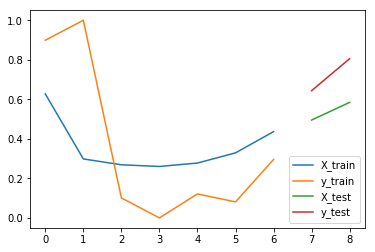

In [95]:
# 예측을 그리프로 시각화
train_len = np.arange(len(X_train))
test_len = np.arange(len(X_train), len(X_train) + len(X_test))
p = plt.plot(train_len, lr.predict(X_train), label='X_train') 
p = plt.plot(train_len, y_train, label='y_train')
p = plt.plot(test_len, lr.predict(X_test), label='X_test')
p = plt.plot(test_len, y_test, label='y_test')
p = plt.legend()

In [58]:
f = 'japan_money.csv'
f = '8.8.1.1 주요국통화의 대원화 환.csv'
df = pd.read_csv(f, encoding='cp949', index_col=0, header=3)
df.shape

(369, 2)

In [59]:
df.head()

,원자료,원자료.1
변환,,
2018/06/29,"1,121.70","1,014.79"
2018/06/30,NaN,NaN
2018/07/01,NaN,NaN
2018/07/02,"1,117.20","1,009.26"
2018/07/03,"1,117.40","1,008.26"


데이터 정제(refinement)

In [61]:
#df4 = df.iloc[:,:4]
#df4 = df4.dropna() # NaN 하나라도 있으면 그 행을 버린다.
df.columns = ['달러','엔']
df2 = df.dropna()
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 248 entries, 2018/06/29 to 2019/07/02
Data columns (total 2 columns):
달러    248 non-null object
엔     248 non-null object
dtypes: object(2)
memory usage: 5.8+ KB


In [64]:
df2 = df2.replace(',','',regex=True)
df2 = df2.astype(np.float)

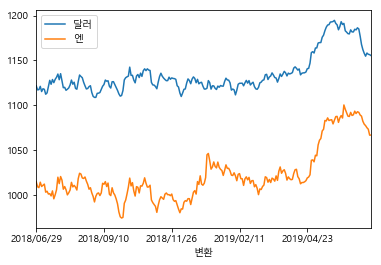

In [65]:
#df4.tail()
df2.plot()

In [66]:
window_weak = 4
window_day = window_weak * 5 # 20일
predict_day = 5

X, Y 갯수 체크
- 데이터가 30개 있으면? 20개로부터 5일 예측하므로 (20+5)=1샘플, 총 6샘플
  - 참조해야할일 : window_day(1주에 5일 * 4주) = 20일
  - 예측일 : predict_day = 5
  - 샘플 생성 수식 :  len(df2) - (predict_day + window_day -1)
  - 30 - (5 + 20 -1) = 6
  - 1샘플 : 1~20 + 21~25, 2샘플 : 2~21 + 22~26, 3샘플 : 3~22 + 23~27, 6샘플: 6~25 + 26~30
- 현재 데이터 248개 샘플, 총 224쌍의 X,Y를 만들어야 합니다.
  - 샘플 생성 수식 :  len(df2) - (predict_day + window_day -1)
  - 248 - (5 + 20 -1) = 224
  - X[224, 2 * 20], Y[224,2 * 5]


In [76]:
len(df2), window_day+predict_day, len(df2)-(window_day+predict_day-1)

(248, 25, 224)

In [77]:
offset = window_day+predict_day-1
offset, len(df2)-offset

(24, 224)

In [80]:
before = df2.iloc[:-predict_day] # 최근 데이터 5개 빼고
before.shape

(243, 2)

In [81]:
later = df2.iloc[window_day:] # 과거 데이터 20개 빼고
later.shape

(228, 2)

In [82]:
m = len(df2) - (predict_day + window_day -1)
m

224

In [87]:
x_list = []
y_list = []
for i in range(m):
    x = df2.iloc[i:i+window_day]  # 20일간의 데이터
    y = df2.iloc[i+window_day:i+window_day+predict_day]  # 그다음 5일간의 데이터
    x_list.append(x.values)         # 날짜 인덱스 빼고 값만 저장
    y_list.append(y.values)

In [89]:
X = np.array(x_list)
y = np.array(y_list)
X.shape, y.shape  #(m-instance, day, 특징수(달러, 엔화))

((224, 20, 2), (224, 5, 2))

In [90]:
# 2차원으로 변환
X = np.reshape(X,[m, -1])
y = np.reshape(y,[m, -1])

In [92]:
X.shape, y.shape # (달러, 엔화, 달러, 엔화....)

((224, 40), (224, 10))

In [121]:
X

array([[1121.7 , 1014.79, 1117.2 , ..., 1020.63, 1127.5 , 1016.73],
       [1117.2 , 1009.26, 1117.4 , ..., 1016.73, 1119.6 , 1006.52],
       [1117.4 , 1008.26, 1121.1 , ..., 1006.52, 1120.  , 1009.46],
       ...,
       [1191.2 , 1087.41, 1189.6 , ..., 1089.16, 1167.7 , 1087.9 ],
       [1189.6 , 1087.63, 1184.1 , ..., 1087.9 , 1162.  , 1082.19],
       [1184.1 , 1080.97, 1187.6 , ..., 1082.19, 1157.9 , 1078.97]])

In [96]:
# train /test 분리
offset = 30 # 테스트셋
X_train = X[offset:]
X_test = X[:offset]
y_train = y[offset:]
y_test = y[:offset]

In [97]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((194, 40), (30, 40), (194, 10), (30, 10))

In [108]:
# 모델 선택, 학습
from sklearn.linear_model import LinearRegression, Ridge, Lasso
lr = Ridge().fit(X_train, y_train)

In [109]:
# 성능 측정
lr.score(X_train, y_train), lr.score(X_test, y_test)

(0.9205409191491469, -0.6542108232125314)

In [115]:
# 미래의 5일 환율 예측을 그래프로 시각화
최근20일데이터 = df2.iloc[-window_day:].values.reshape([1,-1])
미래의5일예측 = lr.predict(최근20일데이터)
미래의5일예측 = np.reshape(미래의5일예측,[predict_day, 2])
미래의5일예측.shape

(5, 2)

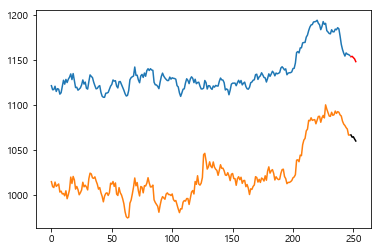

In [118]:
usa = df2.iloc[:,0].values
japan = df2.iloc[:,1].values

# 예측을 그리프로 시각화
x_num = np.arange(len(usa))
x1_num = np.arange(len(usa), len(usa) + len(미래의5일예측))

plt.plot(x_num, usa)
plt.plot(x_num, japan)
plt.plot(x1_num, 미래의5일예측[:,0], c='red')
plt.plot(x1_num, 미래의5일예측[:,1], c='black')